# Computational Methods in Economics

## Problem Set 5 - Multivariate Function Approximation 

In [1]:
# Author: Alex Schmitt (schmitt@ifo.de)

import datetime
print('Last update: ' + str(datetime.datetime.today()))

Last update: 2018-01-19 16:35:40.866729


### Preliminaries

#### Import Modules

In [2]:
import numpy as np
import scipy.optimize

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn

import funapprox_cme as fa

**Note**: The last command imports the **funapprox_cme** module, which contains the functions defined in the last lecture. The Python-file **funapprox_cme.py** which can be downloaded from LSF must be saved in the same folder as this notebook.

## Question 1 (N)

In the lecture, we have approximated the Cobb-Douglas production function with two arguments using a tensor product Chebyshev basis. Repeat this exercise with a complete set of Chebyshev polynomials. Try different values for the total degree $l$ and plot the approximation errors.

**Hint**: You can implement the regression step with the function **chebapprox_2d** that was defined in the lecture, by adding a single line!

#### Answer:

The initial steps are exactly the same as in the lecture: we define the functions, initialize one-dimensional Chebyshev grids and then compute the function values using the **meshgrid** function:

In [3]:
def cd_fun(x1, x2, alpha = 0.33):
    """
    Cobb-Douglas Function
    """
    return x1**alpha * x2**(1 - alpha)

N = 31
## min and max for approximation grid
g1_min, g1_max = 0.1, 2
g2_min, g2_max = 0.001, 1
## equidistant grid
x1 = np.linspace(g1_min, g1_max, N)
x2 = np.linspace(g2_min, g2_max, N)

In [4]:
m = 10
x1_c = fa.chebgrid(g1_min, g1_max, m)
x2_c = fa.chebgrid(g2_min, g2_max, m)

X2_c, X1_c = np.meshgrid(x2_c, x1_c)
Y_c = cd_fun(X1_c, X2_c) 

For the fitting step, the only change to **chebapprox_2d** is that we only compute the coefficient **a[idx_1, idx_2]** whenever **idx_1 + idx_2** is less or equal to the total degree **l**:

In [5]:
## two dimensions
def chebapprox_2d(Z, deg, l):
    """
    Computes the (deg[0]+1)-by-(deg[1]+1) coefficient matrix for approximation with Chebyshev basis functions
    NB: Z must be a m1-by-m2 "meshgrid" matrix
    """
    ## get the dimensions of the grid
    m = Z.shape
    ## check of dimension are consistent
    assert len(m) == len(deg), "Inconsistent dimensions"
  
    ## define one-dimensional Chebyshev matrices    
    A, B = fa.chebmatrix(deg[0], m[0]), fa.chebmatrix(deg[1], m[1])
    
    ## Tensor interpolation in two dimensions
    a = np.zeros(np.array(deg) + 1)
    for idx_1 in range(deg[0] + 1):
        for idx_2 in range(deg[1] + 1):  
            if idx_1 + idx_2 <= l:
                den = (A[:, idx_1].T @ A[:, idx_1]) * (B[:, idx_2].T @ B[:, idx_2])
                a[idx_1, idx_2] = (A[:, idx_1].T @ Z) @ B[:, idx_2] / den
    
    return a
         
totDegree = 2
a = chebapprox_2d(Y_c, [m-1, m-1],totDegree)

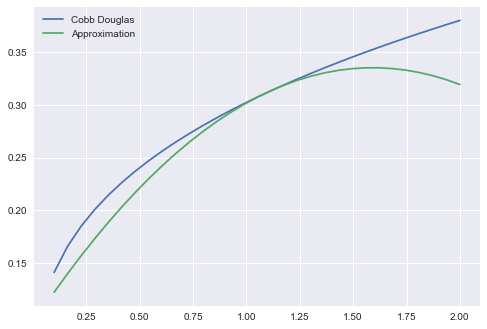

In [6]:
y_app = np.zeros(N)
for idx in range(N):
    y_app[idx] = np.polynomial.chebyshev.chebval2d(fa.chebconvert(x1[idx], g1_min, g1_max), 
                                                   fa.chebconvert(x2[5], g2_min, g2_max), a)  
    
    
fig, ax = plt.subplots()
ax.plot(x1, cd_fun(x1, x2[5]), label = 'Cobb Douglas')
ax.plot(x1, y_app, label = 'Approximation')
ax.legend()

## Question 2 (N)

In the last problem set, we have approximated the value function resulting from the neoclassical growth model. Here, we repeat this exercise for a modified version of the model that has two *state variables*, i.e. the value function is a function of two variables. 

The per-period utility function is the same as before. The production function has three inputs, *two* capital stocks, denoted by $k$ and $q$, and labor. Let's assume the following functional form:
\begin{equation}
    f(k, q, h) = A \left[ (\omega k^{\frac{\sigma - 1}{\sigma}} + (1 - \omega) q^{\frac{\sigma - 1}{\sigma}})^{\frac{\sigma}{\sigma-1}}   \right]^\alpha h^{1-\alpha}
\end{equation}

As before, we have a Cobb-Douglas production function. The first argument is a *CES composite* of the two capital stocks, $k$ and $q$. Recall that a CES function allows you to set an *elasticity of substitution* $\sigma \in [0, \infty)$ different from 1 (which would be the Cobb-Douglas case). For $\sigma < 1$, the two inputs are considered *complements*, while for $\sigma > 1$, they are *substitutes*.

The resource constraint now reads:

\begin{equation}
    k_{t+1} + q_{t+1} + c_t = f(k_t, q_t, h_t) + (1 - \delta) (k_t + q_t)
\end{equation}

where we have assumed that both types of capital depreciate with the same rate $\delta$. 

The planner's problem is identical to before, with the exception that we consider a *finite* time horizon:

\begin{equation}
    \max_{\left\{c_t, k_{t+1}, q_{t+1}, h_t\right\}} \sum^T_{t = 0} \beta^t u(c_t, h_t) 
\end{equation}

s.t. the resource constraint.

As before, we want to approximate the initial *value function* $V$, which now depends on both $k_0$ and $q_0$:

\begin{equation}
    V(k_0, q_0) = \sum^{T-1}_{t = 0} \beta^t u[f(k^*_t, q^*_t, h^*_t) + (1 - \delta) (k^*_t + q^*_t) - k^*_{t+1} - q^*_{t+1}, h^*_t] 
\end{equation}

where $(k^*_t, q^*_t, h^*_t)_{t = 0}^T$ denote the optimal sequences for the capital stocks and labor. 

To find $V$, follow the same steps as before:

(i) Set $T = 2$. Create grids for the initial capital stocks $k_0$ and $q_0$, each consisting of $m$ nodes. Solve the model above for each of the resulting $m^2$ grid points. Store the resulting values $V_{i_1 i_2} = V(k_{0, i_1}, q_{0, i_2})$ in a Numpy array.

(ii) Using the data $\{V_{i_1 i_2}, k_{0, i_1}, q_{0, i_2}\}_{i = 1}^m$, approximate the function $V$. Choose a suitable number of grid points and basis functions. Compare the approximated values for $(k_0, q_0) = (0.66, 0.75)$ with the true value. 


In [7]:
## utility
beta = 0.8      # discount factor
nu = 2       # risk-aversion coefficient for consumption
eta = 1         # elasticity parameter for labor supply
eps = 1e-6      # lower bound of consumption and labor supply
## production
alpha = 0.25
delta = 0.1
## derived
A = (1 - beta * (1 - delta))/(alpha*beta) # normalization parameter for production function => steady state k = 1
B = (1 - alpha) * A * (A - delta)**(-nu)      # parameter for utility function

omega = 0.5
sigma = 0.8

#### Answer

(i)

Start by defining the usual auxiliary functions for production and utility:

In [8]:
def cd(x, y):
    """
    Evaluates the Cobb-Douglas function with coefficient alpha and shift parameter A, for two inputs (x)
    """
    return A * x**alpha * y**(1 - alpha)

def ces(k1, k2):
    
    rho = (sigma - 1) / sigma
    return (omega * k1**rho + (1 - omega) * k2**rho)**(1/rho)


def u(c, h):
    """
    Utility function
    """
    return c**(1 - nu)/(1 - nu) - B * h**(1 + eta)/(1 + eta)

Next, define the objective function. Note that we now have three choice variables in every period - $k_{t+1}$, $q_{t+1}$ and $h_t$ - and hence our solution vector **x** has length $3T$ (here 6 for $T = 2$). 

In [9]:
def objective(x, k0, q0):
    """
    Objective function: lifetime utility
    """
    kp = np.exp( x[:int(len(x)/3)] )
    qp = np.exp( x[int(len(x)/3): 2 * int(len(x)/3)] )
    h = np.exp( x[2 * int(len(x)/3):] )

    k = np.insert(kp[:T-1], 0, k0)
    q = np.insert(qp[:T-1], 0, q0)
    
    return - ( beta**(np.array(range(T))) @ u( cd(ces(k, q), h) + (1 - delta) * (k + q) - kp - qp, h) )

Let us solve the model once to see if we get reasonable results. As expected $k_T$ and $q_T$ are zero for a finite horizon; in period $T$, there is no incentive to invest any more, since the economy ends afterwards.

In [10]:
T = 2
x0 = np.array([0, -100, 0, -100, 0, 0])

## solve model
res = scipy.optimize.minimize(objective, x0, method = 'BFGS', args = (0.5, 0.5), tol = 1e-6)
print(res.message)
print(res.success)
x0 = res.x

print(np.exp(x0))

Optimization terminated successfully.
True
[  2.90258809e-01   3.72007598e-44   2.90258765e-01   3.72007598e-44
   8.28007446e-01   7.41036514e-01]


Next, we define grids for the initial state variables $k_0$ and $q_0$. As usually, we use Chebyshev nodes. We then employ the **meshgrid** function to get arrays representing the Cartesian product of the two one-dimensional grids, as outlined in the lecture.

In [11]:
m = 10
k_min, k_max = 0.1, 0.9
q_min, q_max = 0.1, 0.9
k_grid = fa.chebgrid(k_min, k_max, m)
q_grid = fa.chebgrid(q_min, q_max, m)

Q, K = np.meshgrid(q_grid, k_grid)

Next, we loop over the grid points and solve the problem for each combination of initial states. We store the resulting value in an array **V**.

In [12]:
V = np.zeros((m, m))

for i1 in range(m):
    for i2 in range(m):
        res = scipy.optimize.minimize(objective, x0, method = 'BFGS', args = (K[i1, i2], Q[i1, i2]), tol = 1e-6)
        
        if res.success is not True:
            print( res.message )
        
        V[i1, i2] = - res.fun

(ii)

Given the data in **V** and the grid, we can use Chebyshev approximation to find the basis coefficients, here with interpolation and a tensor product basis:

In [13]:
def chebapprox_2d(Z, deg):
    """
    Computes the (deg[0]+1)-by-(deg[1]+1) coefficient matrix for approximation with Chebyshev basis functions
    NB: Z must be a m1-by-m2 "meshgrid" matrix
    """
    ## get the dimensions of the grid
    m = Z.shape
    ## check if dimensions are consistent
    assert len(m) == len(deg), "Inconsistent dimensions"

    ## define one-dimensional Chebyshev matrices    
    A, B = fa.chebmatrix(deg[0], m[0]), fa.chebmatrix(deg[1], m[1])
    
    ## Tensor interpolation in two dimensions
    coef = np.zeros(np.array(deg) + 1)
    for idx_A in range(deg[0] + 1):
        for idx_B in range(deg[1] + 1):    
            ## compute the denominator
            den = (A[:, idx_A].T @ A[:, idx_A]) * (B[:, idx_B].T @ B[:, idx_B])
            ## compute the coefficients
            coef[idx_A, idx_B] = (A[:, idx_A].T @ Z) @ B[:, idx_B] / den
    
    return coef
         

a = chebapprox_2d(V, [m-1, m-1])

Finally, we compare the approximated value for $(k_0, q_0) = (0.66, 0.75)$ with the true value:

In [14]:
## approximate value
np.polynomial.chebyshev.chebval2d(fa.chebconvert(0.66, k_min, k_max), fa.chebconvert(0.75, q_min, q_max), a)

-1.4682530432140213

In [15]:
## true value: solve model
res = scipy.optimize.minimize(objective, x0, method = 'BFGS', args = (0.66, 0.75), tol = 1e-6)
print(- res.fun)

-1.468249376620206


## Question 3 (N)

The simplest approach to approximating a univariate function $f$ is (piecewise) linear interpolation. As before, define a grid $x_1, ..., x_m$ and compute the function values $f(x_1), ... , f(x_m)$. Then, to approximate $f(x)$, find the two grid points $x_i$ and $x_{i+1}$ that bracket $x$, i.e. such that $x_l \equiv x_i \le x \le x_{i + 1} \equiv x_r $. The interpolant is given by:

\begin{equation}
    \hat{f}(x)=f(x_{l})+{\frac {f(x_{r})-f(x_{l})}{x_{r}-x_{l}}}(x-x_{l})
\end{equation}

(a) Write a function **lin_int** that takes three arguments - a scalar **x** at which to approximate the function, an array **X** consisting of $m$ grid points and an array **Y** containing the function values corresponding to the grid - and that implements this interpolation scheme. Use this function to approximate the sine function $f(x) = \sin(x)$ between 0 and $2\pi$. Compare your result to Numpy's **interp** function. Plot both the approximated and the true function values.

**Hint**: The slightly tricky part here is to find $x_l$ and $x_r$. There are different ways to achieve this; one possibility is Numpy's **argwhere** function. You may want to combine this with a **try/except** statement.

(b) Compute the maximum interpolation error when using linear interpolation on a dense grid between 0 and $2\pi$. Compare this to using Chebyshev interpolation. 

#### Answer

(a) 

In [16]:
def lin_int(x, X, Y):
    """
    Implements one-dimensional piecewise linear interpolation given a grid X and corresponding function values Y, on a point x
    """  
    try:
        pos = np.argwhere(x > X)[-1]
    except:
        pos = 0
            
    return Y[pos] + ((Y[pos + 1] - Y[pos]) / (X[pos + 1] - X[pos])) * (x - X[pos])    

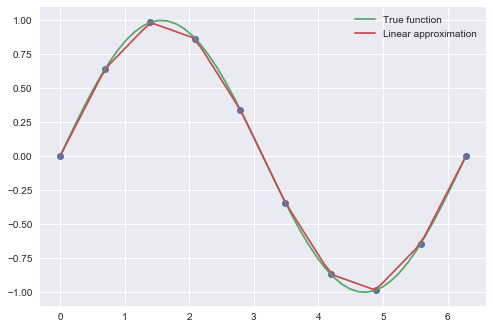

In [17]:
## define grid and compute function values
m = 10
X = np.linspace(0, 2*np.pi, m)
Y = np.sin(X)

## define a dense grid and compute function values
xvals = np.linspace(0, 2*np.pi, 50)
yvals = np.sin(xvals) 

## use lin_int to interpolate function along the dense grid
yapprox = np.zeros(50)
for ind in range(50):
    yapprox[ind] = lin_int(xvals[ind], X, Y)

## plot true and approximated function values     
fig, ax = plt.subplots()   
ax.plot(X, Y, 'o')
ax.plot(xvals, yvals, label = 'True function')
ax.plot(xvals, yapprox, label = 'Linear approximation')
ax.legend()

We can also use the Numpy function **interp**, which gives the same results as our function:

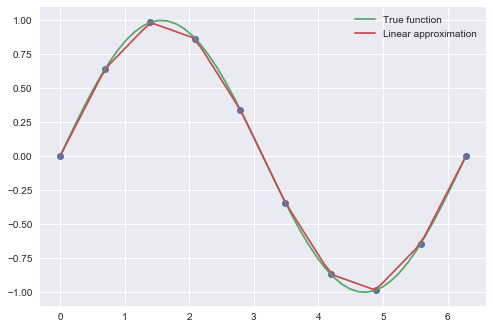

In [18]:
yinterp = np.interp(xvals, X, Y) 

fig, ax = plt.subplots()   
ax.plot(X, Y, 'o')
ax.plot(xvals, yvals, label = 'True function')
ax.plot(xvals, yinterp, label = 'Linear approximation')
ax.legend()


(b) Here, we approximate the function using Chebyshev interpolation and plot the interpolation errors for both approaches:

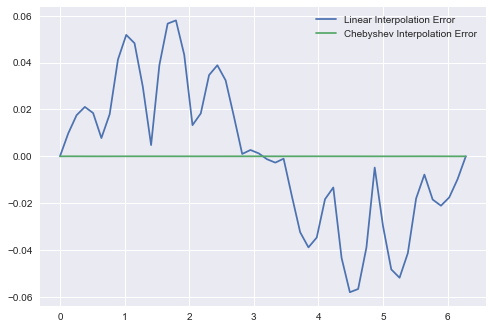

In [19]:
X_cn = fa.chebgrid(0, 2*np.pi, m)
Y_cn = np.sin(X_cn)

a = fa.chebapprox(Y_cn, m - 1)
yapprox_ch = np.polynomial.chebyshev.chebval( fa.chebconvert(xvals, 0, 2*np.pi), a )

fig, ax = plt.subplots()   
ax.plot(xvals, np.sin(xvals) - yapprox, label = 'Linear Interpolation Error')
ax.plot(xvals, np.sin(xvals) - yapprox_ch, label = 'Chebyshev Interpolation Error')
ax.legend()


## Question 4 (N)

This question illustrates the use of interpolation for given grid points. Suppose you have information on some climate indicator, for example the number of hours of sunshine per year, for a finite set of locations, here indexed by latitude and longitude:

Stockholm - 1821 - (59.329444, 18.068611)

Copenhagen - 1539 - (55.676111, 12.568333)

Berlin - 1626 - (52.516667, 13.388889)

Vienna - 1884 - (48.2, 16.366667)

Zagreb - 1913 - (45.816667, 15.983333)

Rome - 2473 - (41.9, 12.5)

The first value gives the annual amount of sunshine, taken from https://en.wikipedia.org/wiki/List_of_cities_by_sunshine_duration; the tuple contains the latitude and longitude of the corresponding city. This data is captured by the following Numpy array:

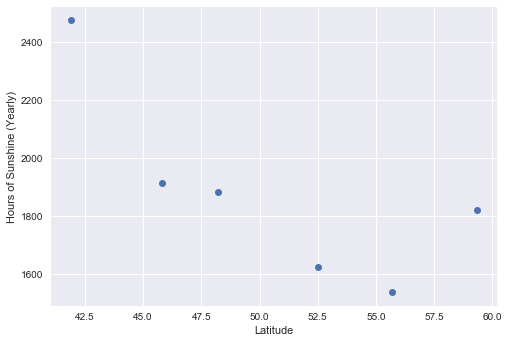

In [20]:
D = np.array([[59.329444, 18.068611, 1821],
              [55.676111, 12.568333, 1539],
              [52.516667, 13.388889, 1626],
              [48.2, 16.366667, 1884],
              [45.816667, 15.983333, 1913],
              [41.9, 12.5, 2473]])

fig, ax = plt.subplots()
ax.plot(D[:,0], D[:,2], 'o')
ax.set_ylabel('Hours of Sunshine (Yearly)')
ax.set_xlabel('Latitude')

(a) Use this data to find a (univariate) function $\hat{f}$ that maps hours of sunshine per year to latitude. We can use this function to predict annual sunshine duration for cities that are not contained in the sample. For example, Prague is represented by the following data:

In [21]:
prague = np.array([50.083333, 14.416667, 1668])

Does $\hat{f}$  over- or underpredict the amount of sunshine in Prague?

(b) Suppose we also include longitude as an explanatory variable in $\hat{f}$ . Does this increase or decrease the interpolation error for Prague? 

#### Answer

(a)

In [22]:
## fitting step

n = 5
a = np.polynomial.chebyshev.chebfit(fa.chebconvert(D[:, 0], D[:, 0].min(), D[:, 0].max() ), D[:,2], n)

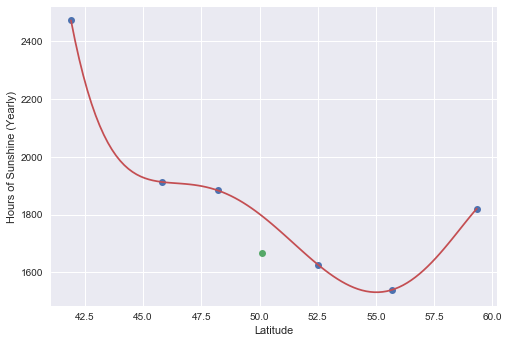

In [23]:
## define dense grid for plotting
lat_dense = np.linspace(D[:, 0].min(), D[:, 0].max(), 100)
sh_approx = np.polynomial.chebyshev.chebval(fa.chebconvert(lat_dense, D[:, 0].min(), D[:, 0].max() ), a)

fig, ax = plt.subplots()
ax.plot(D[:,0], D[:,2], 'o')
ax.plot(prague[0], prague[2], 'o')
ax.plot(lat_dense, sh_approx)
ax.set_ylabel('Hours of Sunshine (Yearly)')
ax.set_xlabel('Latitude')

We can see that the function would overpredict the annual sunshine in Prague (represented by the green point).

(b)

Incorporating a second variable in the approximant $\hat{f}$ is somewhat tricky here, for the simple reason that in this question, we are stuck with six observations. Recall that we want to have at least as many observations/grid points as basis coefficients, and hence the number of basis coefficients is constrained above by 6. 

Assume we use a Tensor product basis. If we set the degree to $n = 1$ in both dimensions (i.e. a linear function), we would have $(n + 1)^2 = 4$ basis coefficients, which would work. 

To find the coefficients, we define the matrix **Phi** containing the Chebyshev polynomials evaluated at the grid points. We then use the regression formula - since we do not use interpolation - to derive the coefficient vector **a_2d**. Note that we cannot use our **chebapprox_2d** here, since we do not use Chebyshev nodes.  

In [24]:
n = 1
Phi = np.polynomial.chebyshev.chebvander2d(fa.chebconvert(D[:, 0], D[:, 0].min(), D[:, 0].max() ), 
                                          fa.chebconvert(D[:, 1], D[:, 1].min(), D[:, 1].max() ), [n, n])
a_2d = np.linalg.inv(Phi.T @ Phi) @ Phi.T @ D[:,2]

Below, we approximate annual sunshine duration for varying latitudes, as above, keeping the second argument (longitude) fixed at the value for Prague. The plot looks different compared to question (a), mainly for the reason that the degree of approximation is lower here ($n = 1$) than it was in the one-dimensional case ($n = 5$), and hence we would expect greater approximation errors.

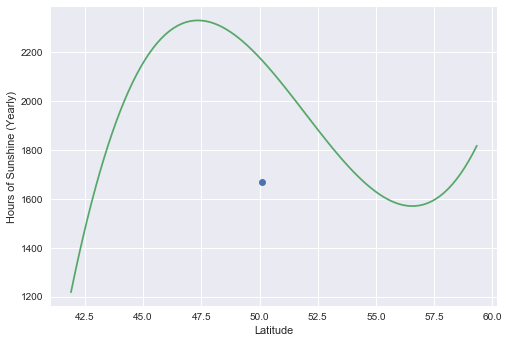

In [25]:
## define dense grid for plotting
lat_dense = np.linspace(D[:, 0].min(), D[:, 0].max(), 100)

sh_approx = np.zeros(100)
for ind in range(100):
    sh_approx[ind] = np.polynomial.chebyshev.chebval2d( fa.chebconvert(lat_dense[ind], D[:, 0].min(), D[:, 0].max()), 
                                           fa.chebconvert(prague[1], D[:, 1].min(), D[:, 1].max()) , a_2d  )

fig, ax = plt.subplots()
# ax.plot(D[:,0], D[:,2], 'o')
ax.plot(prague[0], prague[2], 'o')
ax.plot(lat_dense, sh_approx)
ax.set_ylabel('Hours of Sunshine (Yearly)')
ax.set_xlabel('Latitude')

**How could we increase the quality of the approximation?**


Assuming the number of observations is fixed, we could use a complete set of polynomials rather than a Tensor product basis. This would allow us to include some quadratic terms, since in the case of two dimensions, a total degree of 2 would result in six elements in the basis, i.e. we would have as many basis coefficients as observations. Of course, this may not have a large impact on the approximation. A more promising approach to get a better approximation for the function of interest would be to *increase the number of observations*, if possible.